## Modelling

### Import Neccesary Libraries

In [2]:
! pip install tensorflow

     |████████████████████████████████| 458.3 MB 2.8 kB/s  eta 0:00:01   |                                | 1.0 MB 12.6 MB/s eta 0:00:37     |▏                               | 1.9 MB 12.6 MB/s eta 0:00:37     |▏                               | 2.7 MB 12.6 MB/s eta 0:00:37     |▎                               | 4.4 MB 12.6 MB/s eta 0:00:37     |▍                               | 5.4 MB 12.6 MB/s eta 0:00:37     |▊                               | 10.6 MB 12.6 MB/s eta 0:00:36     |▉                               | 12.3 MB 12.6 MB/s eta 0:00:36     |█                               | 13.3 MB 12.6 MB/s eta 0:00:36     |█                               | 15.0 MB 12.6 MB/s eta 0:00:36     |█▎                              | 17.6 MB 9.6 MB/s eta 0:00:46     |█▎                              | 18.1 MB 9.6 MB/s eta 0:00:46     |█▍                              | 19.8 MB 9.6 MB/s eta 0:00:46     |█▌                              | 20.8 MB 9.6 MB/s eta 0:00:46     |█▌                              | 21.7

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import datetime
import os

In [ ]:
# Import custom helper functions
from helpers import make_windows,train_test_split,model_checkpoint_callback, evaluate_model, predict, plot_series

In [4]:
pd.set_option('display.max_columns', None, 'display.max_rows', 100)

## Import data

In [ ]:
data = pd.read_csv('clean_data.csv')

In [ ]:
data.head(3)

## Split our data into features and labels
We will take a two way to solve this problem, first we will create a model to predict the weather after which we will create another to predict the Rain percentage.

# **Weather prediction data**

In [4]:
weather_X = data.drop('M_WEATHER', axis=1)
weather_y = data['M_WEATHER']

## Split into training and test splits

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
weather_X_train, weather_X_test, weather_y_train, weather_y_test = train_test_split(weather_X, weather_y, test_size=.25, random_state=42)

##### **Model Architecture for Weather Prediction**

In [11]:
# Convert our data to tensors
weather_X_train = tf.constant(tf.cast(weather_X_train, tf.float32))
weather_y_train = tf.constant(tf.cast(weather_y_train, tf.float32))

weather_X_test = tf.constant(tf.cast(weather_X_test, tf.float32))
weather_y_test = tf.constant(tf.cast(weather_y_test, tf.float32))

In [12]:
weather_X_train.shape, weather_X_test.shape, weather_y_train.shape, weather_y_test.shape

(TensorShape([1467808, 37]),
 TensorShape([489270, 37]),
 TensorShape([1467808]),
 TensorShape([489270]))

<AxesSubplot:>

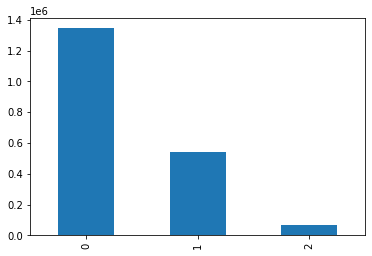

In [13]:
# Visualize the target variable value counts
data['M_WEATHER'].value_counts().plot(kind='bar')

## Experiment 1 (Classification) 🔬

In [ ]:
# Create a random seed to make our model reproducible
tf.random.set_seed(42)

weather_base_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01)),
    tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(1, activation='softmax')
], name='weather_base_model')

# compile our model
weather_base_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           optimizer=tf.keras.optimizers.SGD(),
                           metrics=['accuracy'])

# fit our model
weather_history1 = weather_base_model.fit(weather_X_train, 
                        weather_y_train, 
                        epochs=10, 
                        batch_size=32,
                        validation_data=(weather_X_test, weather_y_test),
                        callbacks=[model_checkpoint_callback('WeatherBaseModel')])

# summarize our model
weather_base_model.summary()

In [15]:
def plot_history(history):
    """
    Returns a plots of model learning history object
    Args:
        history: Model's learning history object
    
    Returns:
        A plot of of model learning history
    """

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Plot the histories
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")
    plt.xlabel('Epochs')
    plt.title('Loss Curves')
    plt.legend()

    # Plot the accuracy
    plt.figure()
    plt.plot(train_accuracy, label="Train Accuracy")
    plt.plot(val_accuracy, label="Val Accuracy")
    plt.xlabel('Epochs')
    plt.title('Accuracy')
    plt.legend()

In [ ]:
plot_history(weather_history1)

😌 Right now we are experiencing an exploding gradients problem. This is obviously because:

* The model is unable to get traction on our training data (e.g. poor loss).
* The model is unstable, resulting in large changes in loss from update to update.
* The model loss goes to NaN during training.


## Experiment 2 (Classification) 🔬

What we will change:
* The output layer activation function: Change from Softmax - Sigmoid
* Adjust the batch size by adopting `Yann Lecun's` proposed batch size for batches
* Change our optimizer to `SGD() Stochastic Gradient Descent`

In [50]:
# Create a random seed to make our model reproducible
tf.random.set_seed(42)

experiment2 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='softmax', kernel_initializer='he_uniform')
], name='experiment2')

# compile our model
experiment2.compile(loss=tf.keras.losses.SparseCategoricalcrossentropy(),
                           optimizer=tf.keras.optimizers.SGD(),
                           metrics=['mae','accuracy'])

# fit our model
experiment_history_2 = experiment2.fit(weather_X_train, 
                        weather_y_train, 
                        epochs=10, 
                        batch_size=32,
                        validation_data=(weather_X_test, weather_y_test),
                        callbacks=[model_checkpoint_callback('Experiment2')])

# summarize our model
experiment2.summary()

Epoch 1/10
64333/64339 [============================>.] - ETA: 0s - loss: 4.1993e-08 - mae: 0.4893 - accuracy: 0.6781
Epoch 00001: saving model to Callbacks/checkpoints/2022_02_23_203828_experiment2
INFO:tensorflow:Assets written to: Callbacks/checkpoints/2022_02_23_203828_experiment2/assets
64339/64339 [==============================] - 184s 3ms/step - loss: 4.1993e-08 - mae: 0.4893 - accuracy: 0.6781 - val_loss: 4.1919e-08 - val_mae: 0.4891 - val_accuracy: 0.6776
Epoch 2/10
64338/64339 [============================>.] - ETA: 0s - loss: 4.1993e-08 - mae: 0.4893 - accuracy: 0.6781
Epoch 00002: saving model to Callbacks/checkpoints/2022_02_23_203828_experiment2
INFO:tensorflow:Assets written to: Callbacks/checkpoints/2022_02_23_203828_experiment2/assets
64339/64339 [==============================] - 186s 3ms/step - loss: 4.1993e-08 - mae: 0.4893 - accuracy: 0.6781 - val_loss: 4.1919e-08 - val_mae: 0.4891 - val_accuracy: 0.6776
Epoch 3/10
64323/64339 [============================>.] - ET

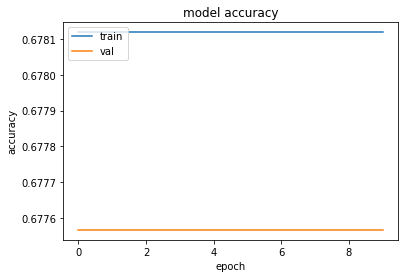

In [58]:
plt.plot(experiment_history_2.history['accuracy'])
plt.plot(experiment_history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Experiment 3 (Classification) 🔬

In [7]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, log_loss

r_model = RandomForestClassifier(n_estimators=100)
r_model = r_model.fit(weather_X_train, weather_y_train)

In [8]:
# Score experiment 4 model
r_model.score(weather_X_test, weather_y_test)

1.0

In [9]:
# Make a prediction on Experiment 3
r_pred = r_model.predict_proba(weather_X_test)

In [10]:
# find the log loss metric
loss = log_loss(weather_y_test, r_pred)
loss

1.2697544963867406e-06

## 

**Conclusion:** We will settle with experiment 4, since it's the best performing model so far

# **Rain Percentage prediction data**

## Split our data into features and labels
We will take a two way to solve this problem, first we will create a model to predict the weather after which we will create another to predict the Rain percentage.

In [11]:
rain_X = data.drop('M_RAIN_PERCENTAGE', axis=1)
rain_y = data['M_RAIN_PERCENTAGE']

In [12]:
rain_X_train, rain_X_test, rain_y_train, rain_y_test = train_test_split(rain_X, rain_y, test_size=.25, random_state=42)

## Experiment 1 (Regression) 🔬

In [13]:
from sklearn.ensemble import RandomForestRegressor

In [14]:
rg_model = RandomForestRegressor(n_estimators=100)
rg_model = rg_model.fit(rain_X_train, rain_y_train)

In [15]:
rg_score = rg_model.score(rain_X_train, rain_y_train)
rg_score

0.9999975360596536

In [16]:
from sklearn.metrics import mean_absolute_error
rg_pred = rg_model.predict(rain_X_test)
mean_absolute_error(rain_y_test, rg_pred)

0.00011661420994346334

## MultiOutput Classifier🔬
Multilabel classification support can be added to any classifier with MultiOutputClassifier. This strategy consists of fitting one classifier per target. This allows multiple target variable classifications. The purpose of this class is to extend estimators to be able to estimate a series of target functions (f1,f2,f3…,fn) that are trained on a single X predictor matrix to predict a series of responses (y1,y2,y3…,yn).


**Source:** https://scikit-learn.org/stable/modules/multiclass.html#multioutputclassifier


**Note** This is aimed at helping us return the multiple predictions at once


In [17]:
# Split the data into features and variables
X = data.drop(['M_WEATHER','M_RAIN_PERCENTAGE'], axis=1)
y = data[['M_WEATHER','M_RAIN_PERCENTAGE']]

In [18]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=42)

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
moc_model = MultiOutputClassifier(r_model)
# fit the model
moc_model = moc_model.fit(X_train, y_train)

In [ ]:
# Scoring the model based on accuracy
moc_model.score(X_test, y_test)

In [ ]:
import pickle

In [ ]:
def test_predict(X, model):
    """
    returns a test json response of prediction across the periods of [5,10,15,30,60]
    """
    output = dict()
    periods = [5,10,15,30,60]
    
    for i in periods:
        #Assign an offset to the picked offset
        X['M_TIME_OFFSET'] = i
        prediction = model.predict([X])
        
        output[i] = {
            'weather_type': int(prediction[0][0]),
            'rain_percentage' : round(prediction[0][1],2)
        }
    return json.dumps(output)

In [ ]:
input_X = X_test.iloc[10]

In [ ]:
# make prediction on test
print(test_predict(input_X, moc_model))

In [ ]:

pickle.dump(moc_model, open('model.pkl', 'wb')))